Universidad del Valle de Guatemala  
Departamento de Ciencias de la Computación  
Minería de Datos - sección 30  

Cristian Túnchez - 231359  
Javier Linares - 231135

---

# Proyecto 1: Análisis Exploratorio y Clustering

## 1. Consolidación de Datos de Divorcios 2010-2020

In [3]:
# Importar librerías necesarias
import pyreadstat
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("Librerías cargadas exitosamente")

Librerías cargadas exitosamente


In [4]:
# Paso 1: Explorar la estructura de cada archivo

years = range(2010, 2021)
file_info = {}

for year in years:
    filename = f'datasets/INE_Divorcios_{year}.sav'
    df, meta = pyreadstat.read_sav(filename)
    file_info[year] = {
        'shape': df.shape,
        'columns': df.columns.tolist()
    }
    print(f'{year}: {df.shape[0]} registros, {df.shape[1]} columnas')

print(f'\nTotal de archivos cargados: {len(file_info)}')

2010: 3645 registros, 19 columnas
2011: 4344 registros, 19 columnas
2012: 5157 registros, 18 columnas
2013: 5542 registros, 18 columnas
2014: 5575 registros, 18 columnas
2015: 5726 registros, 19 columnas
2016: 5665 registros, 19 columnas
2017: 5808 registros, 19 columnas
2018: 6255 registros, 19 columnas
2019: 8203 registros, 19 columnas
2020: 4074 registros, 19 columnas

Total de archivos cargados: 11


In [5]:
# Paso 2: Identificar años con columnas faltantes
# Verificamos cuáles años NO tienen la columna de año de ocurrencia

print("Verificación de columna AÑOOCU:")
for year in years:
    cols_lower = [c.lower() for c in file_info[year]['columns']]
    has_anoocu = 'añoocu' in cols_lower
    symbol = '✓' if has_anoocu else '✗ FALTA'
    print(f'  {year}: {symbol}')

Verificación de columna AÑOOCU:
  2010: ✓
  2011: ✓
  2012: ✗ FALTA
  2013: ✗ FALTA
  2014: ✗ FALTA
  2015: ✓
  2016: ✓
  2017: ✓
  2018: ✓
  2019: ✓
  2020: ✓


### Paso 3: Definir mapeo de estandarización de columnas

**Decisiones tomadas:**
- **Esquema objetivo**: camelCase para nombres de columnas
- **Estrategia**: Convertir todos los nombres a minúsculas primero, luego aplicar mapeo único
- **Columnas identificadas como equivalentes**:
  - `grethom/gethom/puehom/pperhom` → `grupoEtnicoHombre`
  - `gretmuj/getmuj/puemuj/ppermuj` → `grupoEtnicoMujer`
  - `escohom/eschom` → `escolaridadHombre`
  - `escomuj/escmuj` → `escolaridadMujer`
  - `ocupahom/ocuhom/ciuohom` → `ocupacionHombre`
  - `ocupamuj/ocumuj/ciuomuj` → `ocupacionMujer`

In [6]:
# Mapeo único para todas las variaciones de nombres de columnas
# Se convertirán todas las columnas a minúsculas antes de aplicar este mapeo
column_mapping = {
    'depreg': 'departamentoRegistro',
    'mupreg': 'municipioRegistro',
    'mesreg': 'mesRegistro',
    'añoreg': 'anioRegistro',
    'diaocu': 'diaOcurrencia',
    'mesocu': 'mesOcurrencia',
    'añoocu': 'anioOcurrencia',
    'depocu': 'departamentoOcurrencia',
    'mupocu': 'municipioOcurrencia',
    'edadhom': 'edadHombre',
    'edadmuj': 'edadMujer',
    'grethom': 'grupoEtnicoHombre',
    'gethom': 'grupoEtnicoHombre',
    'puehom': 'grupoEtnicoHombre',
    'pperhom': 'grupoEtnicoHombre',
    'gretmuj': 'grupoEtnicoMujer',
    'getmuj': 'grupoEtnicoMujer',
    'puemuj': 'grupoEtnicoMujer',
    'ppermuj': 'grupoEtnicoMujer',
    'nachom': 'nacionalidadHombre',
    'nacmuj': 'nacionalidadMujer',
    'escohom': 'escolaridadHombre',
    'eschom': 'escolaridadHombre',
    'escomuj': 'escolaridadMujer',
    'escmuj': 'escolaridadMujer',
    'ocupahom': 'ocupacionHombre',
    'ocuhom': 'ocupacionHombre',
    'ciuohom': 'ocupacionHombre',
    'ocupamuj': 'ocupacionMujer',
    'ocumuj': 'ocupacionMujer',
    'ciuomuj': 'ocupacionMujer'
}

print(f"Mapeo de columnas definido ({len(set(column_mapping.values()))} columnas únicas).")

Mapeo de columnas definido (19 columnas únicas).


### Paso 4: Cargar, estandarizar y consolidar todos los archivos

**Proceso:**
1. Cargar cada archivo .sav
2. Convertir nombres de columnas a minúsculas
3. Crear columna `añoocu` para los años 2012-2014 (usando el año del archivo)
4. Aplicar el mapeo único de columnas
5. Concatenar todos los DataFrames en uno solo

In [7]:
# Función para procesar un archivo según su año
def procesar_archivo(year):
    """Carga y procesa un archivo .sav según su año"""
    filename = f'datasets/INE_Divorcios_{year}.sav'
    df, meta = pyreadstat.read_sav(filename)
    
    # Convertir todos los nombres de columnas a minúsculas
    df.columns = df.columns.str.lower()
    
    # Verificar si falta la columna añoocu (años 2012-2014)
    if 'añoocu' not in df.columns:
        # Crear la columna usando el año del archivo
        df['añoocu'] = year
    
    # Aplicar el mapeo de columnas
    df = df.rename(columns=column_mapping)
    
    return df

# Procesar todos los archivos
print("Procesando archivos...")
dataframes = []

for year in years:
    df = procesar_archivo(year)
    dataframes.append(df)
    print(f'- {year}: {df.shape[0]:,} registros, {df.shape[1]} columnas')

print(f'\nTotal archivos procesados: {len(dataframes)}')

Procesando archivos...


- 2010: 3,645 registros, 19 columnas
- 2011: 4,344 registros, 19 columnas
- 2012: 5,157 registros, 19 columnas
- 2013: 5,542 registros, 19 columnas
- 2014: 5,575 registros, 19 columnas
- 2015: 5,726 registros, 19 columnas
- 2016: 5,665 registros, 19 columnas
- 2017: 5,808 registros, 19 columnas
- 2018: 6,255 registros, 19 columnas
- 2019: 8,203 registros, 19 columnas
- 2020: 4,074 registros, 19 columnas

Total archivos procesados: 11


In [8]:
# Paso 5: Consolidar todos los DataFrames en uno solo
df_consolidado = pd.concat(dataframes, ignore_index=True)

print("="*60)
print("DATASET FINAL - DIVORCIOS GUATEMALA 2010-2020")
print("="*60)
print(f"\nDimensiones: {df_consolidado.shape[0]:,} filas × {df_consolidado.shape[1]} columnas")
print("Período: 2010-2020")
print(f"Memoria utilizada: {df_consolidado.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATASET FINAL - DIVORCIOS GUATEMALA 2010-2020

Dimensiones: 59,994 filas × 19 columnas
Período: 2010-2020
Memoria utilizada: 18.42 MB


### Paso 6: Visualización del dataset consolidado

In [9]:
# Lista de columnas estandarizadas
print("COLUMNAS DEL DATASET CONSOLIDADO:")
print("-" * 60)
for i, col in enumerate(df_consolidado.columns, 1):
    print(f"{i:2}. {col}")
print("-" * 60)
print(f"Total: {len(df_consolidado.columns)} columnas")

COLUMNAS DEL DATASET CONSOLIDADO:
------------------------------------------------------------
 1. departamentoRegistro
 2. municipioRegistro
 3. mesRegistro
 4. anioRegistro
 5. diaOcurrencia
 6. mesOcurrencia
 7. anioOcurrencia
 8. departamentoOcurrencia
 9. municipioOcurrencia
10. edadHombre
11. edadMujer
12. grupoEtnicoHombre
13. grupoEtnicoMujer
14. nacionalidadHombre
15. nacionalidadMujer
16. escolaridadHombre
17. escolaridadMujer
18. ocupacionHombre
19. ocupacionMujer
------------------------------------------------------------
Total: 19 columnas


In [10]:
# Primeras 5 filas del dataset consolidado
print("\nPRIMERAS 5 FILAS DEL DATASET:")
print("=" * 100)
df_consolidado.head()


PRIMERAS 5 FILAS DEL DATASET:


,departamentoRegistro,municipioRegistro,mesRegistro,anioRegistro,diaOcurrencia,mesOcurrencia,anioOcurrencia,departamentoOcurrencia,municipioOcurrencia,edadHombre,edadMujer,grupoEtnicoHombre,grupoEtnicoMujer,nacionalidadHombre,nacionalidadMujer,escolaridadHombre,escolaridadMujer,ocupacionHombre,ocupacionMujer
0,1.0,0101,8.0,2010.0,4.0,5.0,2010.0,1.0,0101,41.0,35.0,9.0,9.0,320.0,320.0,9.0,9.0,1120.0,1120.0
1,1.0,0101,11.0,2010.0,6.0,10.0,2010.0,1.0,0101,999.0,999.0,9.0,9.0,320.0,320.0,9.0,9.0,2161.0,1219.0
2,1.0,0101,3.0,2010.0,16.0,2.0,2010.0,1.0,0101,42.0,31.0,9.0,9.0,320.0,320.0,4.0,9.0,2166.0,1219.0
3,1.0,0101,10.0,2010.0,25.0,8.0,2010.0,1.0,0101,47.0,36.0,9.0,9.0,320.0,320.0,1.0,1.0,5221.0,1219.0
4,1.0,0101,8.0,2010.0,20.0,5.0,2010.0,1.0,0101,999.0,999.0,9.0,9.0,840.0,484.0,9.0,9.0,9712.0,1219.0


## 2. Limpieza de Datos

**Objetivo**: Aplicar técnicas de limpieza para garantizar la calidad y consistencia de los datos antes del análisis exploratorio.

### 2.1. Análisis de valores faltantes (NaN explícitos)

In [11]:
# Crear copia del dataset para trabajar en limpieza
df_limpio = df_consolidado.copy()

print("Dataset original:")
print(f"- Registros: {len(df_limpio):,}")
print(f"- Columnas: {len(df_limpio.columns)}")

Dataset original:
- Registros: 59,994
- Columnas: 19


In [12]:
# Análisis de valores faltantes explícitos (NaN)
missing_data = pd.DataFrame({
    'Variable': df_limpio.columns,
    'NaN_Count': df_limpio.isnull().sum(),
    'NaN_Percent': (df_limpio.isnull().sum() / len(df_limpio) * 100).round(2)
})

missing_data = missing_data[missing_data['NaN_Count'] > 0].sort_values('NaN_Count', ascending=False)

print("="*70)
print("VALORES FALTANTES EXPLÍCITOS (NaN)")
print("="*70)
if len(missing_data) > 0:
    print(missing_data.to_string(index=False))
else:
    print("No se encontraron valores NaN explícitos en el dataset")
print("="*70)

VALORES FALTANTES EXPLÍCITOS (NaN)
          Variable  NaN_Count  NaN_Percent
nacionalidadHombre          1          0.0
 nacionalidadMujer          1          0.0


### 2.2. Identificación de valores especiales que representan "faltantes"

En datos del INE, ciertos códigos numéricos y strings representan información faltante o no especificada:

| Variable | Códigos que representan "faltante" |
|----------|-----------------------------------|
| Edad | 999 |
| Escolaridad | 9 |
| Nacionalidad | 9999 |
| Grupo Étnico | 9 |
| Ocupación | 9999, 9998, 97, 98, 99, 'NEOG', 'IGNORADO' |

Estos valores deben tratarse como faltantes para no distorsionar estadísticas descriptivas ni análisis.

In [13]:
# Definir diccionario de valores especiales que representan faltantes
valores_faltantes = {
    'edadHombre': [999],
    'edadMujer': [999],
    'escolaridadHombre': [9],
    'escolaridadMujer': [9],
    'nacionalidadHombre': [9999],
    'nacionalidadMujer': [9999],
    'grupoEtnicoHombre': [9],
    'grupoEtnicoMujer': [9],
    'ocupacionHombre': [9999, 9998, 97, 98, 99, 'NEOG', 'IGNORADO'],
    'ocupacionMujer': [9999, 9998, 97, 98, 99, 'NEOG', 'IGNORADO']
}

print("Identificando valores especiales que representan faltantes...")
print("="*70)

# Contar valores especiales antes de reemplazar
resumen_especiales = []

for columna, valores in valores_faltantes.items():
    if columna in df_limpio.columns:
        # Contar cuántos registros tienen estos valores
        mask = df_limpio[columna].isin(valores)
        count = mask.sum()
        percent = (count / len(df_limpio) * 100)
        
        if count > 0:
            resumen_especiales.append({
                'Variable': columna,
                'Valores_Especiales': count,
                'Porcentaje': f"{percent:.2f}%"
            })

df_especiales = pd.DataFrame(resumen_especiales)
if len(df_especiales) > 0:
    print(df_especiales.to_string(index=False))
else:
    print("No se encontraron valores especiales")
    
print("="*70)

Identificando valores especiales que representan faltantes...
          Variable  Valores_Especiales Porcentaje
        edadHombre               33640     56.07%
         edadMujer               33503     55.84%
 escolaridadHombre               32857     54.77%
  escolaridadMujer               32454     54.10%
nacionalidadHombre                 198      0.33%
 nacionalidadMujer                 208      0.35%
 grupoEtnicoHombre               36239     60.40%
  grupoEtnicoMujer               36290     60.49%
   ocupacionHombre               27637     46.07%
    ocupacionMujer               39766     66.28%


In [14]:
# Reemplazar valores especiales por NaN
import numpy as np

print("Reemplazando valores especiales por NaN...")

for columna, valores in valores_faltantes.items():
    if columna in df_limpio.columns:
        # Reemplazar cada valor especial por NaN
        df_limpio[columna] = df_limpio[columna].replace(valores, np.nan)

print("Valores especiales reemplazados por NaN exitosamente")

Reemplazando valores especiales por NaN...
Valores especiales reemplazados por NaN exitosamente


In [15]:
# Análisis completo de valores faltantes (después de tratar valores especiales)
missing_complete = pd.DataFrame({
    'Variable': df_limpio.columns,
    'Faltantes': df_limpio.isnull().sum(),
    'Porcentaje': (df_limpio.isnull().sum() / len(df_limpio) * 100).round(2),
    'Presentes': df_limpio.notnull().sum(),
    'Completitud': (df_limpio.notnull().sum() / len(df_limpio) * 100).round(2)
})

missing_complete = missing_complete.sort_values('Faltantes', ascending=False)

print("="*80)
print("REPORTE COMPLETO DE VALORES FALTANTES")
print("="*80)
print(missing_complete.to_string(index=False))
print("="*80)
print(f"\nTotal de registros: {len(df_limpio):,}")

REPORTE COMPLETO DE VALORES FALTANTES
              Variable  Faltantes  Porcentaje  Presentes  Completitud
        ocupacionMujer      39766       66.28      20228        33.72
      grupoEtnicoMujer      36290       60.49      23704        39.51
     grupoEtnicoHombre      36239       60.40      23755        39.60
            edadHombre      33640       56.07      26354        43.93
             edadMujer      33503       55.84      26491        44.16
     escolaridadHombre      32857       54.77      27137        45.23
      escolaridadMujer      32454       54.10      27540        45.90
       ocupacionHombre      27637       46.07      32357        53.93
     nacionalidadMujer        209        0.35      59785        99.65
    nacionalidadHombre        199        0.33      59795        99.67
         diaOcurrencia          0        0.00      59994       100.00
         mesOcurrencia          0        0.00      59994       100.00
        anioOcurrencia          0        0.00      5

### 2.3. Decisión sobre tratamiento de valores faltantes

**Análisis y justificación**:

1. **Variables de identificación temporal y geográfica** (departamento, municipio, fechas):
   - **Decisión**: Mantener registros con valores faltantes
   - **Justificación**: Son variables de contexto. La falta de alguna no invalida el registro completo

2. **Variables demográficas** (edad, escolaridad, ocupación, etnia, nacionalidad):
   - **Decisión**: Mantener registros, NO imputar
   - **Justificación**: 
     - Imputar datos demográficos puede introducir sesgos significativos
     - Para análisis exploratorio, es preferible identificar patrones en datos disponibles
     - Las tasas de faltantes son relativamente bajas en variables críticas
     - Se utilizarán solo registros completos cuando sea necesario en análisis específicos

3. **Estrategia general**: 
   - NO eliminar registros globalmente
   - Aplicar filtrado selectivo según el análisis específico
   - Documentar limitaciones en interpretaciones

### 2.4. Conversión de tipos de datos

In [16]:
# Análisis de tipos de datos actuales
print("TIPOS DE DATOS ACTUALES:")
print("="*70)
tipos_actuales = df_limpio.dtypes.to_frame('Tipo')
tipos_actuales['Tipo'] = tipos_actuales['Tipo'].astype(str)
print(tipos_actuales.to_string())
print("="*70)

TIPOS DE DATOS ACTUALES:
                           Tipo
departamentoRegistro    float64
municipioRegistro        object
mesRegistro             float64
anioRegistro            float64
diaOcurrencia           float64
mesOcurrencia           float64
anioOcurrencia          float64
departamentoOcurrencia  float64
municipioOcurrencia      object
edadHombre              float64
edadMujer               float64
grupoEtnicoHombre       float64
grupoEtnicoMujer        float64
nacionalidadHombre      float64
nacionalidadMujer       float64
escolaridadHombre       float64
escolaridadMujer        float64
ocupacionHombre          object
ocupacionMujer           object


In [17]:
# Definir conversiones de tipos de datos
print("\nConvirtiendo tipos de datos...")

# Variables numéricas enteras (temporales)
columnas_int = ['diaOcurrencia', 'mesOcurrencia', 'anioOcurrencia', 
                'mesRegistro', 'anioRegistro']

for col in columnas_int:
    if col in df_limpio.columns:
        df_limpio[col] = pd.to_numeric(df_limpio[col], errors='coerce').astype('Int64')
        print(f"- {col}: convertida a Int64")

# Variables de edad (numéricas)
columnas_edad = ['edadHombre', 'edadMujer']
for col in columnas_edad:
    if col in df_limpio.columns:
        df_limpio[col] = pd.to_numeric(df_limpio[col], errors='coerce').astype('Int64')
        print(f"- {col}: convertida a Int64")

# Variables categóricas (códigos)
columnas_cat = ['departamentoRegistro', 'municipioRegistro', 
                'departamentoOcurrencia', 'municipioOcurrencia',
                'grupoEtnicoHombre', 'grupoEtnicoMujer',
                'nacionalidadHombre', 'nacionalidadMujer',
                'escolaridadHombre', 'escolaridadMujer']

for col in columnas_cat:
    if col in df_limpio.columns:
        df_limpio[col] = df_limpio[col].astype('category')
        print(f"- {col}: convertida a category")

# Variables de ocupación (pueden ser string o numeric)
columnas_ocup = ['ocupacionHombre', 'ocupacionMujer']
for col in columnas_ocup:
    if col in df_limpio.columns:
        df_limpio[col] = df_limpio[col].astype('category')
        print(f"- {col}: convertida a category")

print("\nConversión de tipos completada :)")


Convirtiendo tipos de datos...
- diaOcurrencia: convertida a Int64
- mesOcurrencia: convertida a Int64
- anioOcurrencia: convertida a Int64
- mesRegistro: convertida a Int64
- anioRegistro: convertida a Int64
- edadHombre: convertida a Int64
- edadMujer: convertida a Int64
- departamentoRegistro: convertida a category
- municipioRegistro: convertida a category
- departamentoOcurrencia: convertida a category
- municipioOcurrencia: convertida a category
- grupoEtnicoHombre: convertida a category
- grupoEtnicoMujer: convertida a category
- nacionalidadHombre: convertida a category
- nacionalidadMujer: convertida a category
- escolaridadHombre: convertida a category
- escolaridadMujer: convertida a category
- ocupacionHombre: convertida a category
- ocupacionMujer: convertida a category

Conversión de tipos completada :)


In [18]:
# Verificar tipos de datos después de conversión
print("\nTIPOS DE DATOS DESPUÉS DE CONVERSIÓN:")
print("="*70)
tipos_nuevos = df_limpio.dtypes.to_frame('Tipo')
tipos_nuevos['Tipo'] = tipos_nuevos['Tipo'].astype(str)
print(tipos_nuevos.to_string())
print("="*70)


TIPOS DE DATOS DESPUÉS DE CONVERSIÓN:
                            Tipo
departamentoRegistro    category
municipioRegistro       category
mesRegistro                Int64
anioRegistro               Int64
diaOcurrencia              Int64
mesOcurrencia              Int64
anioOcurrencia             Int64
departamentoOcurrencia  category
municipioOcurrencia     category
edadHombre                 Int64
edadMujer                  Int64
grupoEtnicoHombre       category
grupoEtnicoMujer        category
nacionalidadHombre      category
nacionalidadMujer       category
escolaridadHombre       category
escolaridadMujer        category
ocupacionHombre         category
ocupacionMujer          category


### 2.5. Detección y tratamiento de edades imposibles

**Criterios de validación**:
- **Edad mínima legal para divorciarse en Guatemala**: 18 años (mayoría de edad)
- **Edad máxima razonable**: 100 años
- **Valores a considerar anómalos**: < 10 o > 100 años

**Justificación**: 
- Edades menores a 10 años son claramente errores de captura
- Edades entre 10-17 son posibles en casos especiales pero poco comunes
- Edades mayores a 100 años son extremadamente raras y podrían ser errores

In [19]:
# Análisis de distribución de edades
print("ANÁLISIS DE EDADES")
print("="*70)

for col in ['edadHombre', 'edadMujer']:
    if col in df_limpio.columns:
        print(f"\n{col}:")
        print(f"  Total registros no nulos: {df_limpio[col].notna().sum():,}")
        print(f"  Mínimo: {df_limpio[col].min()}")
        print(f"  Máximo: {df_limpio[col].max()}")
        print(f"  Media: {df_limpio[col].mean():.1f}")
        print(f"  Mediana: {df_limpio[col].median():.1f}")
        
        # Contar edades problemáticas
        menor_10 = (df_limpio[col] < 10).sum()
        entre_10_17 = ((df_limpio[col] >= 10) & (df_limpio[col] < 18)).sum()
        mayor_100 = (df_limpio[col] > 100).sum()
        
        print(f"\n  Edades < 10 años: {menor_10:,} ({menor_10/len(df_limpio)*100:.2f}%)")
        print(f"  Edades 10-17 años: {entre_10_17:,} ({entre_10_17/len(df_limpio)*100:.2f}%)")
        print(f"  Edades > 100 años: {mayor_100:,} ({mayor_100/len(df_limpio)*100:.2f}%)")

print("="*70)

ANÁLISIS DE EDADES

edadHombre:
  Total registros no nulos: 26,354
  Mínimo: 15
  Máximo: 96
  Media: 35.5
  Mediana: 33.0

  Edades < 10 años: 0 (0.00%)
  Edades 10-17 años: 5 (0.01%)
  Edades > 100 años: 0 (0.00%)

edadMujer:
  Total registros no nulos: 26,491
  Mínimo: 14
  Máximo: 80
  Media: 32.2
  Mediana: 30.0

  Edades < 10 años: 0 (0.00%)
  Edades 10-17 años: 149 (0.25%)
  Edades > 100 años: 0 (0.00%)


In [20]:
# Identificar registros con edades problemáticas
print("\nIDENTIFICACIÓN DE EDADES PROBLEMÁTICAS:")
print("="*70)

# Crear máscaras para edades problemáticas
mask_edad_problematica = (
    (df_limpio['edadHombre'] < 10) | 
    (df_limpio['edadHombre'] > 100) |
    (df_limpio['edadMujer'] < 10) | 
    (df_limpio['edadMujer'] > 100)
)

registros_problematicos = mask_edad_problematica.sum()
print(f"Total registros con edades problemáticas: {registros_problematicos:,}")
print(f"Porcentaje: {registros_problematicos/len(df_limpio)*100:.2f}%")

if registros_problematicos > 0:
    print("\nEjemplos de registros problemáticos:")
    cols_mostrar = ['edadHombre', 'edadMujer', 'anioOcurrencia']
    print(df_limpio[mask_edad_problematica][cols_mostrar].head(10).to_string())

print("="*70)


IDENTIFICACIÓN DE EDADES PROBLEMÁTICAS:
Total registros con edades problemáticas: 0
Porcentaje: 0.00%


In [21]:
# Tratamiento de edades problemáticas
print("\nTRATAMIENTO DE EDADES PROBLEMÁTICAS:")
print("="*70)

# DECISIÓN: Reemplazar edades imposibles por NaN
# Justificación: Son claramente errores, mejor tratarlos como faltantes

# Edades menores a 10 o mayores a 100
for col in ['edadHombre', 'edadMujer']:
    if col in df_limpio.columns:
        # Contar antes
        antes = df_limpio[col].notna().sum()
        
        # Reemplazar valores imposibles
        df_limpio.loc[(df_limpio[col] < 10) | (df_limpio[col] > 100), col] = np.nan
        
        # Contar después
        despues = df_limpio[col].notna().sum()
        convertidos = antes - despues
        
        print(f"✓ {col}:")
        print(f"  - Valores convertidos a NaN: {convertidos:,}")
        print(f"  - Valores válidos restantes: {despues:,}")

print("\n✓ Tratamiento de edades completado")
print("="*70)


TRATAMIENTO DE EDADES PROBLEMÁTICAS:
✓ edadHombre:
  - Valores convertidos a NaN: 0
  - Valores válidos restantes: 26,354
✓ edadMujer:
  - Valores convertidos a NaN: 0
  - Valores válidos restantes: 26,491

✓ Tratamiento de edades completado


### 2.6. Validación de variables temporales

**Objetivo**: Verificar que fechas y años estén dentro de rangos esperados

In [22]:
# Validación de variables temporales
print("VALIDACIÓN DE VARIABLES TEMPORALES:")
print("="*70)

# Año de ocurrencia
if 'anioOcurrencia' in df_limpio.columns:
    print("\nAño de Ocurrencia:")
    print(f"  Rango: {df_limpio['anioOcurrencia'].min()} - {df_limpio['anioOcurrencia'].max()}")
    print(f"  Valores únicos: {df_limpio['anioOcurrencia'].nunique()}")
    
    # Verificar años fuera del rango esperado (2010-2020)
    fuera_rango = ((df_limpio['anioOcurrencia'] < 2010) | 
                (df_limpio['anioOcurrencia'] > 2020)).sum()
    print(f"  Años fuera de 2010-2020: {fuera_rango:,}")

# Mes de ocurrencia
if 'mesOcurrencia' in df_limpio.columns:
    print("\nMes de Ocurrencia:")
    print(f"  Rango: {df_limpio['mesOcurrencia'].min()} - {df_limpio['mesOcurrencia'].max()}")
    invalidos = ((df_limpio['mesOcurrencia'] < 1) | 
                (df_limpio['mesOcurrencia'] > 12)).sum()
    print(f"  Meses inválidos (< 1 o > 12): {invalidos:,}")

# Día de ocurrencia
if 'diaOcurrencia' in df_limpio.columns:
    print("\nDía de Ocurrencia:")
    print(f"  Rango: {df_limpio['diaOcurrencia'].min()} - {df_limpio['diaOcurrencia'].max()}")
    invalidos = ((df_limpio['diaOcurrencia'] < 1) | 
                (df_limpio['diaOcurrencia'] > 31)).sum()
    print(f"  Días inválidos (< 1 o > 31): {invalidos:,}")

print("="*70)

VALIDACIÓN DE VARIABLES TEMPORALES:

Año de Ocurrencia:
  Rango: 2010 - 2020
  Valores únicos: 11
  Años fuera de 2010-2020: 0

Mes de Ocurrencia:
  Rango: 1 - 12
  Meses inválidos (< 1 o > 12): 0

Día de Ocurrencia:
  Rango: 1 - 31
  Días inválidos (< 1 o > 31): 0


### 2.7. Estandarización de categorías

In [23]:
# Análisis de variables categóricas
print("ANÁLISIS DE VARIABLES CATEGÓRICAS:")
print("="*70)

variables_categoricas = ['grupoEtnicoHombre', 'grupoEtnicoMujer',
                        'nacionalidadHombre', 'nacionalidadMujer',
                        'escolaridadHombre', 'escolaridadMujer']

for var in variables_categoricas:
    if var in df_limpio.columns:
        print(f"\n{var}:")
        print(f"  Categorías únicas: {df_limpio[var].nunique()}")
        print(f"  Valores no nulos: {df_limpio[var].notna().sum():,}")
        print("  Top 5 categorías:")
        top5 = df_limpio[var].value_counts().head(5)
        for cat, count in top5.items():
            print(f"    {cat}: {count:,} ({count/len(df_limpio)*100:.1f}%)")

print("="*70)

ANÁLISIS DE VARIABLES CATEGÓRICAS:

grupoEtnicoHombre:
  Categorías únicas: 5
  Valores no nulos: 23,755
  Top 5 categorías:
    4.0: 17,210 (28.7%)
    1.0: 3,870 (6.5%)
    2.0: 2,438 (4.1%)
    5.0: 236 (0.4%)
    3.0: 1 (0.0%)

grupoEtnicoMujer:
  Categorías únicas: 5
  Valores no nulos: 23,704
  Top 5 categorías:
    4.0: 17,400 (29.0%)
    1.0: 3,580 (6.0%)
    2.0: 2,460 (4.1%)
    5.0: 263 (0.4%)
    3.0: 1 (0.0%)

nacionalidadHombre:
  Categorías únicas: 66
  Valores no nulos: 59,795
  Top 5 categorías:
    320.0: 58,795 (98.0%)
    840.0: 218 (0.4%)
    222.0: 146 (0.2%)
    720.0: 73 (0.1%)
    484.0: 50 (0.1%)

nacionalidadMujer:
  Categorías únicas: 53
  Valores no nulos: 59,785
  Top 5 categorías:
    320.0: 58,771 (98.0%)
    840.0: 246 (0.4%)
    222.0: 227 (0.4%)
    720.0: 85 (0.1%)
    340.0: 68 (0.1%)

escolaridadHombre:
  Categorías únicas: 7
  Valores no nulos: 27,137
  Top 5 categorías:
    4.0: 8,595 (14.3%)
    1.0: 7,290 (12.2%)
    2.0: 4,569 (7.6%)
    3.0: 

In [24]:
# Análisis de ocupaciones (pueden tener muchas categorías)
print("\nANÁLISIS DE OCUPACIONES:")
print("="*70)

for var in ['ocupacionHombre', 'ocupacionMujer']:
    if var in df_limpio.columns:
        print(f"\n{var}:")
        print(f"  Categorías únicas: {df_limpio[var].nunique()}")
        print(f"  Valores no nulos: {df_limpio[var].notna().sum():,}")
        print("  Top 10 ocupaciones:")
        top10 = df_limpio[var].value_counts().head(10)
        for i, (cat, count) in enumerate(top10.items(), 1):
            print(f"    {i}. {cat}: {count:,} ({count/len(df_limpio)*100:.1f}%)")

print("="*70)


ANÁLISIS DE OCUPACIONES:

ocupacionHombre:
  Categorías únicas: 379
  Valores no nulos: 32,357
  Top 10 ocupaciones:
    1. 92.0: 4,254 (7.1%)
    2. 9712.0: 2,229 (3.7%)
    3. 52.0: 2,076 (3.5%)
    4. 9999: 1,610 (2.7%)
    5. 9712: 1,423 (2.4%)
    6. 43.0: 1,291 (2.2%)
    7. 61: 1,148 (1.9%)
    8. 23.0: 907 (1.5%)
    9. 6111.0: 880 (1.5%)
    10. 72.0: 831 (1.4%)

ocupacionMujer:
  Categorías únicas: 248
  Valores no nulos: 20,228
  Top 10 ocupaciones:
    1. 9712.0: 2,119 (3.5%)
    2. 23.0: 1,864 (3.1%)
    3. 9999: 1,822 (3.0%)
    4. 9711.0: 1,639 (2.7%)
    5. 41.0: 1,504 (2.5%)
    6. 9712: 1,336 (2.2%)
    7. 9711: 1,048 (1.7%)
    8. 43.0: 781 (1.3%)
    9. 52.0: 631 (1.1%)
    10. 23: 552 (0.9%)


Las categorías están codificadas numéricamente por el INE. Se mantendrán tal cual para el análisis exploratorio. En fases posteriores, se crearán diccionarios de mapeo a etiquetas descriptivas.

### 2.8. Dataset final

**Decisiones clave**:
- **No se eliminaron registros**: Se mantiene la completitud del dataset
- **Valores faltantes preservados**: Permiten análisis sobre patrones de datos faltantes
- **Tipos de datos optimizados**: Int64 (maneja NaN) y category (eficiente en memoria)

In [25]:
# Resumen final del dataset limpio
print("="*70)
print("DATASET FINAL LIMPIO - DIVORCIOS GUATEMALA 2010-2020")
print("="*70)
print("\nDIMENSIONES:")
print(f"   Registros: {len(df_limpio):,}")
print(f"   Variables: {len(df_limpio.columns)}")

print("\nMEMORIA:")
print(f"   Uso total: {df_limpio.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nCOMPLETITUD GENERAL:")
total_valores = df_limpio.shape[0] * df_limpio.shape[1]
valores_presentes = df_limpio.notna().sum().sum()
completitud_total = (valores_presentes / total_valores * 100)
print(f"   Valores presentes: {valores_presentes:,} de {total_valores:,}")
print(f"   Completitud global: {completitud_total:.2f}%")

print("\nVARIABLES CLAVE:")
vars_clave = ['edadHombre', 'edadMujer', 'anioOcurrencia', 
            'departamentoOcurrencia', 'grupoEtnicoHombre', 'grupoEtnicoMujer']
for var in vars_clave:
    if var in df_limpio.columns:
        completitud_var = (df_limpio[var].notna().sum() / len(df_limpio) * 100)
        print(f"   {var}: {completitud_var:.1f}% completo")

print("\n" + "="*70)
print("Dataset limpio y listo para análisis exploratorio :)")
print("="*70)

DATASET FINAL LIMPIO - DIVORCIOS GUATEMALA 2010-2020

DIMENSIONES:
   Registros: 59,994
   Variables: 19

MEMORIA:
   Uso total: 4.63 MB

COMPLETITUD GENERAL:
   Valores presentes: 867,092 de 1,139,886
   Completitud global: 76.07%

VARIABLES CLAVE:
   edadHombre: 43.9% completo
   edadMujer: 44.2% completo
   anioOcurrencia: 100.0% completo
   departamentoOcurrencia: 100.0% completo
   grupoEtnicoHombre: 39.6% completo
   grupoEtnicoMujer: 39.5% completo

Dataset limpio y listo para análisis exploratorio :)


In [26]:
# Vista previa del dataset limpio
print("\nVISTA PREVIA DEL DATASET LIMPIO:")
print("="*100)
df_limpio.head(10)


VISTA PREVIA DEL DATASET LIMPIO:


,departamentoRegistro,municipioRegistro,mesRegistro,anioRegistro,diaOcurrencia,mesOcurrencia,anioOcurrencia,departamentoOcurrencia,municipioOcurrencia,edadHombre,edadMujer,grupoEtnicoHombre,grupoEtnicoMujer,nacionalidadHombre,nacionalidadMujer,escolaridadHombre,escolaridadMujer,ocupacionHombre,ocupacionMujer
0,1.0,0101,8,2010,4,5,2010,1.0,0101,41,35,NaN,NaN,320.0,320.0,NaN,NaN,1120.0,1120.0
1,1.0,0101,11,2010,6,10,2010,1.0,0101,<NA>,<NA>,NaN,NaN,320.0,320.0,NaN,NaN,2161.0,1219.0
2,1.0,0101,3,2010,16,2,2010,1.0,0101,42,31,NaN,NaN,320.0,320.0,4.0,NaN,2166.0,1219.0
3,1.0,0101,10,2010,25,8,2010,1.0,0101,47,36,NaN,NaN,320.0,320.0,1.0,1.0,5221.0,1219.0
4,1.0,0101,8,2010,20,5,2010,1.0,0101,<NA>,<NA>,NaN,NaN,840.0,484.0,NaN,NaN,9712.0,1219.0
5,16.0,1601,3,2010,28,1,2010,16.0,1601,23,37,2.0,2.0,320.0,320.0,NaN,3.0,9712.0,1221.0
6,1.0,0101,10,2010,23,6,2010,1.0,0101,<NA>,<NA>,NaN,NaN,320.0,320.0,NaN,NaN,5249.0,1346.0
7,1.0,0101,11,2010,24,8,2010,1.0,0101,<NA>,<NA>,NaN,NaN,320.0,320.0,NaN,NaN,1219.0,1411.0
8,1.0,0101,9,2010,15,7,2010,1.0,0101,<NA>,<NA>,2.0,2.0,320.0,320.0,5.0,5.0,2113.0,2131.0
9,1.0,0101,11,2010,8,9,2010,1.0,0101,33,33,NaN,NaN,320.0,320.0,NaN,NaN,2611.0,2141.0


In [27]:
# Información detallada del dataset
print("\nINFORMACIÓN DETALLADA DEL DATASET:")
print("="*70)
df_limpio.info()
print("="*70)


INFORMACIÓN DETALLADA DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59994 entries, 0 to 59993
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   departamentoRegistro    59994 non-null  category
 1   municipioRegistro       59994 non-null  category
 2   mesRegistro             59994 non-null  Int64   
 3   anioRegistro            59994 non-null  Int64   
 4   diaOcurrencia           59994 non-null  Int64   
 5   mesOcurrencia           59994 non-null  Int64   
 6   anioOcurrencia          59994 non-null  Int64   
 7   departamentoOcurrencia  59994 non-null  category
 8   municipioOcurrencia     59994 non-null  category
 9   edadHombre              26354 non-null  Int64   
 10  edadMujer               26491 non-null  Int64   
 11  grupoEtnicoHombre       23755 non-null  category
 12  grupoEtnicoMujer        23704 non-null  category
 13  nacionalidadHombre      59795 non-null  

## 3. Descripción Formal del Dataset

Esta sección presenta una caracterización técnica del dataset consolidado de divorcios en Guatemala para el período 2010-2020, posterior al proceso de limpieza y estandarización. La descripción incluye dimensiones del conjunto de datos, taxonomía de variables y documentación semántica.

### 3.1. Dimensiones del Dataset

In [28]:
# Dimensiones del dataset consolidado
n_observaciones = len(df_limpio)
n_variables = len(df_limpio.columns)

print("="*70)
print("CARACTERIZACIÓN DIMENSIONAL DEL DATASET")
print("="*70)
print(f"\nObservaciones (n): {n_observaciones:,}")
print(f"Variables (p): {n_variables}")
print(f"\n   Razón n/p: {n_observaciones/n_variables:,.1f}")
print(f"   Total de valores: {n_observaciones * n_variables:,}")
print("="*70)

CARACTERIZACIÓN DIMENSIONAL DEL DATASET

Observaciones (n): 59,994
Variables (p): 19

   Razón n/p: 3,157.6
   Total de valores: 1,139,886


### 3.2. Taxonomía de Variables

Las variables del dataset se clasifican según los siguientes criterios estadísticos:

1. **Variables Numéricas Discretas**: Valores enteros que representan conteos o categorías ordinales
2. **Variables Numéricas Continuas**: En este dataset no aplica, todas las numéricas son discretas
3. **Variables Categóricas Nominales**: Categorías sin orden inherente
4. **Variables Categóricas Ordinales**: Categorías con orden jerárquico

**Nota**: Las variables de ocupación, aunque codificadas numéricamente según clasificación CIUO (Clasificación Internacional Uniforme de Ocupaciones), se tratan como categóricas nominales debido a que los códigos no representan un orden intrínseco.

In [29]:
# Clasificación taxonómica de variables
import pandas as pd

# Definir taxonomía de variables
taxonomia = {
    # Variables temporales (numéricas discretas)
    'diaOcurrencia': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Día del mes en que ocurrió el divorcio (1-31)',
        'categoria': 'Temporal'
    },
    'mesOcurrencia': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Mes del año en que ocurrió el divorcio (1-12)',
        'categoria': 'Temporal'
    },
    'anioOcurrencia': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Año en que ocurrió el divorcio (2010-2020)',
        'categoria': 'Temporal'
    },
    'mesRegistro': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Mes en que se registró el divorcio (1-12)',
        'categoria': 'Temporal'
    },
    'anioRegistro': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Año en que se registró el divorcio',
        'categoria': 'Temporal'
    },
    
    # Variables geográficas (categóricas nominales)
    'departamentoRegistro': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código del departamento donde se registró el divorcio',
        'categoria': 'Geográfica'
    },
    'municipioRegistro': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código del municipio donde se registró el divorcio',
        'categoria': 'Geográfica'
    },
    'departamentoOcurrencia': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código del departamento donde ocurrió el divorcio',
        'categoria': 'Geográfica'
    },
    'municipioOcurrencia': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código del municipio donde ocurrió el divorcio',
        'categoria': 'Geográfica'
    },
    
    # Variables demográficas - Edad (numéricas discretas)
    'edadHombre': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Edad del esposo al momento del divorcio (años completos)',
        'categoria': 'Demográfica'
    },
    'edadMujer': {
        'tipo': 'Numérica Discreta',
        'descripcion': 'Edad de la esposa al momento del divorcio (años completos)',
        'categoria': 'Demográfica'
    },
    
    # Variables demográficas - Grupo étnico (categóricas nominales)
    'grupoEtnicoHombre': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de autoidentificación étnica del esposo',
        'categoria': 'Demográfica'
    },
    'grupoEtnicoMujer': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de autoidentificación étnica de la esposa',
        'categoria': 'Demográfica'
    },
    
    # Variables demográficas - Nacionalidad (categóricas nominales)
    'nacionalidadHombre': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de nacionalidad del esposo',
        'categoria': 'Demográfica'
    },
    'nacionalidadMujer': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de nacionalidad de la esposa',
        'categoria': 'Demográfica'
    },
    
    # Variables socio-educativas - Escolaridad (categóricas ordinales)
    'escolaridadHombre': {
        'tipo': 'Categórica Ordinal',
        'descripcion': 'Nivel máximo de escolaridad alcanzado por el esposo',
        'categoria': 'Socio-educativa'
    },
    'escolaridadMujer': {
        'tipo': 'Categórica Ordinal',
        'descripcion': 'Nivel máximo de escolaridad alcanzado por la esposa',
        'categoria': 'Socio-educativa'
    },
    
    # Variables socio-económicas - Ocupación (categóricas nominales)
    'ocupacionHombre': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de ocupación del esposo según clasificación CIUO',
        'categoria': 'Socio-económica'
    },
    'ocupacionMujer': {
        'tipo': 'Categórica Nominal',
        'descripcion': 'Código de ocupación de la esposa según clasificación CIUO',
        'categoria': 'Socio-económica'
    }
}

# Crear DataFrame de taxonomía
df_taxonomia = pd.DataFrame.from_dict(taxonomia, orient='index')
df_taxonomia.index.name = 'Variable'
df_taxonomia = df_taxonomia.reset_index()

print("Taxonomía de variables definida correctamente")
print(f"Total de variables clasificadas: {len(df_taxonomia)}")

Taxonomía de variables definida correctamente
Total de variables clasificadas: 19


In [30]:
# Resumen cuantitativo por tipo de variable
print("="*70)
print("DISTRIBUCIÓN DE VARIABLES POR TIPO")
print("="*70)

# Contar por tipo
conteo_tipos = df_taxonomia['tipo'].value_counts()
print("\n- Por tipo estadístico:")
for tipo, count in conteo_tipos.items():
    porcentaje = (count / len(df_taxonomia)) * 100
    print(f"   • {tipo}: {count} ({porcentaje:.1f}%)")

# Contar por categoría semántica
print("\n- Por categoría semántica:")
conteo_categorias = df_taxonomia['categoria'].value_counts()
for cat, count in conteo_categorias.items():
    porcentaje = (count / len(df_taxonomia)) * 100
    print(f"   • {cat}: {count} ({porcentaje:.1f}%)")

print("="*70)

DISTRIBUCIÓN DE VARIABLES POR TIPO

- Por tipo estadístico:
   • Categórica Nominal: 10 (52.6%)
   • Numérica Discreta: 7 (36.8%)
   • Categórica Ordinal: 2 (10.5%)

- Por categoría semántica:
   • Demográfica: 6 (31.6%)
   • Temporal: 5 (26.3%)
   • Geográfica: 4 (21.1%)
   • Socio-educativa: 2 (10.5%)
   • Socio-económica: 2 (10.5%)


### 3.3. Tabla Descriptiva de Variables

La siguiente tabla presenta la documentación completa de cada variable, incluyendo su identificador, tipo estadístico, categoría semántica y descripción operacional.

In [31]:
# Mostrar tabla completa de variables
print("\n" + "="*100)
print("TABLA DESCRIPTIVA DE VARIABLES DEL DATASET")
print("="*100)
print()

# Configurar pandas para mostrar toda la tabla
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Mostrar tabla ordenada por categoría
df_taxonomia_ordenada = df_taxonomia.sort_values(['categoria', 'Variable'])
print(df_taxonomia_ordenada.to_string(index=False))

print("\n" + "="*100)

# Restablecer opciones
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')
pd.reset_option('display.width')


TABLA DESCRIPTIVA DE VARIABLES DEL DATASET

              Variable               tipo                                                descripcion       categoria
            edadHombre  Numérica Discreta   Edad del esposo al momento del divorcio (años completos)     Demográfica
             edadMujer  Numérica Discreta Edad de la esposa al momento del divorcio (años completos)     Demográfica
     grupoEtnicoHombre Categórica Nominal             Código de autoidentificación étnica del esposo     Demográfica
      grupoEtnicoMujer Categórica Nominal           Código de autoidentificación étnica de la esposa     Demográfica
    nacionalidadHombre Categórica Nominal                          Código de nacionalidad del esposo     Demográfica
     nacionalidadMujer Categórica Nominal                        Código de nacionalidad de la esposa     Demográfica
departamentoOcurrencia Categórica Nominal          Código del departamento donde ocurrió el divorcio      Geográfica
  departamentoRegis

### 3.4. Características Operacionales del Dataset

**Propiedades estructurales:**

1. **Granularidad**: Cada observación representa un evento de divorcio único registrado entre 2010-2020
2. **Temporalidad**: Dataset de corte transversal con componente temporal agregado
3. **Completitud**: Dataset con valores faltantes (estrategia: conservación sin imputación)
4. **Codificación**: Variables categóricas codificadas según estándares del INE de Guatemala

In [32]:
# Resumen estadístico por tipo de variable

print("="*70)
print("RESUMEN ESTADÍSTICO POR TIPO DE VARIABLE")
print("="*70)

# Variables numéricas discretas
vars_numericas = ['diaOcurrencia', 'mesOcurrencia', 'anioOcurrencia', 
                'mesRegistro', 'anioRegistro', 'edadHombre', 'edadMujer']

print("\n1. VARIABLES NUMÉRICAS DISCRETAS:")
print("-" * 70)
for var in vars_numericas:
    if var in df_limpio.columns:
        print(f"\n   {var}:")
        print(f"      Rango: [{df_limpio[var].min()}, {df_limpio[var].max()}]")
        print(f"      Media: {df_limpio[var].mean():.2f}")
        print(f"      Mediana: {df_limpio[var].median():.1f}")
        print(f"      Desv. Est.: {df_limpio[var].std():.2f}")
        print(f"      Valores únicos: {df_limpio[var].nunique()}")

print("\n" + "="*70)

RESUMEN ESTADÍSTICO POR TIPO DE VARIABLE

1. VARIABLES NUMÉRICAS DISCRETAS:
----------------------------------------------------------------------

   diaOcurrencia:
      Rango: [1, 31]
      Media: 15.72
      Mediana: 16.0
      Desv. Est.: 8.69
      Valores únicos: 31

   mesOcurrencia:
      Rango: [1, 12]
      Media: 6.32
      Mediana: 6.0
      Desv. Est.: 3.31
      Valores únicos: 12

   anioOcurrencia:
      Rango: [2010, 2020]
      Media: 2015.36
      Mediana: 2016.0
      Desv. Est.: 3.02
      Valores únicos: 11

   mesRegistro:
      Rango: [1, 12]
      Media: 6.57
      Mediana: 7.0
      Desv. Est.: 3.43
      Valores únicos: 12

   anioRegistro:
      Rango: [2010, 2021]
      Media: 2015.59
      Mediana: 2016.0
      Desv. Est.: 3.05
      Valores únicos: 12

   edadHombre:
      Rango: [15, 96]
      Media: 35.51
      Mediana: 33.0
      Desv. Est.: 10.21
      Valores únicos: 76

   edadMujer:
      Rango: [14, 80]
      Media: 32.16
      Mediana: 30.0
    

In [33]:
# Resumen de variables categóricas

print("="*70)
print("RESUMEN DE VARIABLES CATEGÓRICAS")
print("="*70)

# Variables categóricas por grupo
grupos_categoricas = {
    'Geográficas': ['departamentoRegistro', 'municipioRegistro', 
                    'departamentoOcurrencia', 'municipioOcurrencia'],
    'Demográficas (Nominal)': ['grupoEtnicoHombre', 'grupoEtnicoMujer',
                               'nacionalidadHombre', 'nacionalidadMujer'],
    'Socio-educativas (Ordinal)': ['escolaridadHombre', 'escolaridadMujer'],
    'Socio-económicas (Nominal)': ['ocupacionHombre', 'ocupacionMujer']
}

for grupo, variables in grupos_categoricas.items():
    print(f"\n{grupo}:")
    print("-" * 70)
    for var in variables:
        if var in df_limpio.columns:
            n_categorias = df_limpio[var].nunique()
            n_validos = df_limpio[var].notna().sum()
            completitud = (n_validos / len(df_limpio)) * 100
            print(f"   • {var}:")
            print(f"      Categorías únicas: {n_categorias}")
            print(f"      Registros válidos: {n_validos:,} ({completitud:.1f}%)")

print("\n" + "="*70)

RESUMEN DE VARIABLES CATEGÓRICAS

Geográficas:
----------------------------------------------------------------------
   • departamentoRegistro:
      Categorías únicas: 22
      Registros válidos: 59,994 (100.0%)
   • municipioRegistro:
      Categorías únicas: 336
      Registros válidos: 59,994 (100.0%)
   • departamentoOcurrencia:
      Categorías únicas: 22
      Registros válidos: 59,994 (100.0%)
   • municipioOcurrencia:
      Categorías únicas: 337
      Registros válidos: 59,994 (100.0%)

Demográficas (Nominal):
----------------------------------------------------------------------
   • grupoEtnicoHombre:
      Categorías únicas: 5
      Registros válidos: 23,755 (39.6%)
   • grupoEtnicoMujer:
      Categorías únicas: 5
      Registros válidos: 23,704 (39.5%)
   • nacionalidadHombre:
      Categorías únicas: 66
      Registros válidos: 59,795 (99.7%)
   • nacionalidadMujer:
      Categorías únicas: 53
      Registros válidos: 59,785 (99.7%)

Socio-educativas (Ordinal):
-------

## 4. Análisis de Variables Numéricas

Esta sección presenta un análisis descriptivo exhaustivo de las variables numéricas del dataset, incluyendo medidas de tendencia central, dispersión, visualizaciones y evaluación de distribuciones estadísticas.

In [34]:
# Importar librerías para análisis y visualización
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Configuración de estilo para visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Librerías de visualización cargadas correctamente")

Librerías de visualización cargadas correctamente


### 4.1. Estadísticos Descriptivos

Análisis de medidas de tendencia central, dispersión y posición para cada variable numérica.

In [ ]:
# Seleccionar variables numéricas
variables_numericas = ['edadHombre', 'edadMujer', 'anioOcurrencia', 
                    'mesOcurrencia', 'diaOcurrencia']

# Crear DataFrame con estadísticos descriptivos completos
estadisticos = []

for var in variables_numericas:
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        stats_dict = {
            'Variable': var,
            'n': len(data),
            'Media': data.mean(),
            'Mediana': data.median(),
            'Moda': data.mode()[0] if len(data.mode()) > 0 else np.nan,
            'Desv.Est.': data.std(),
            'Varianza': data.var(),
            'Mínimo': data.min(),
            'Q1': data.quantile(0.25),
            'Q2 (Mediana)': data.quantile(0.50),
            'Q3': data.quantile(0.75),
            'Máximo': data.max(),
            'Rango': data.max() - data.min(),
            'IQR': data.quantile(0.75) - data.quantile(0.25),
            'Asimetría': data.skew(),
            'Curtosis': data.kurtosis()
        }
        estadisticos.append(stats_dict)

df_estadisticos = pd.DataFrame(estadisticos)

print("="*100)
print("ESTADÍSTICOS DESCRIPTIVOS - VARIABLES NUMÉRICAS")
print("="*100)
print("\nNota: Todas las estadísticas calculadas sobre valores no nulos")
print("\n" + df_estadisticos.to_string(index=False))
print("="*100)

ESTADÍSTICOS DESCRIPTIVOS - VARIABLES NUMÉRICAS

Nota: Todas las estadísticas calculadas sobre valores no nulos

      Variable     n       Media  Mediana  Moda  Desv.Est.   Varianza  Mínimo     Q1  Q2 (Mediana)     Q3  Máximo  Rango  IQR  Asimetría  Curtosis
    edadHombre 26354   35.514229     33.0    29  10.212119 104.287374      15   28.0          33.0   41.0      96     81 13.0   1.161980  1.534568
     edadMujer 26491   32.162621     30.0    27   9.301147  86.511341      14   25.0          30.0   37.0      80     66 12.0   1.056266  1.229743
anioOcurrencia 59994 2015.358319   2016.0  2019   3.015062   9.090597    2010 2013.0        2016.0 2018.0    2020     10  5.0  -0.156024 -1.164419
 mesOcurrencia 59994    6.316465      6.0    10   3.306499  10.932935       1    3.0           6.0    9.0      12     11  6.0   0.021569 -1.174693
 diaOcurrencia 59994   15.718105     16.0     3   8.694661  75.597130       1    8.0          16.0   23.0      31     30 15.0   0.015329 -1.196763


In [41]:
# Resumen interpretativo de estadísticos
print("\n" + "="*80)
print("INTERPRETACIÓN DE ESTADÍSTICOS CLAVE")
print("="*80)

for var in variables_numericas:
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        print(f"\n- {var}:")
        print(f"   • Tendencia central: Media={data.mean():.2f}, Mediana={data.median():.2f}")
        
        # Interpretar asimetría
        skewness = data.skew()
        if abs(skewness) < 0.5:
            simetria = "aproximadamente simétrica"
        elif skewness > 0:
            simetria = f"asimétrica positiva (sesgo derecha, skew={skewness:.2f})"
        else:
            simetria = f"asimétrica negativa (sesgo izquierda, skew={skewness:.2f})"
        print(f"   • Forma: Distribución {simetria}")
        
        # Interpretar curtosis
        kurt = data.kurtosis()
        if kurt > 0:
            curtosis_interp = f"leptocúrtica (colas pesadas, kurt={kurt:.2f})"
        elif kurt < 0:
            curtosis_interp = f"platicúrtica (colas ligeras, kurt={kurt:.2f})"
        else:
            curtosis_interp = "mesocúrtica (normal)"
        print(f"   • Curtosis: {curtosis_interp}")
        
        # Coeficiente de variación
        cv = (data.std() / data.mean()) * 100
        print(f"   • Variabilidad: CV={cv:.2f}% (Desv.Est./Media)")

print("\n" + "="*80)


INTERPRETACIÓN DE ESTADÍSTICOS CLAVE

- edadHombre:
   • Tendencia central: Media=35.51, Mediana=33.00
   • Forma: Distribución asimétrica positiva (sesgo derecha, skew=1.16)
   • Curtosis: leptocúrtica (colas pesadas, kurt=1.53)
   • Variabilidad: CV=28.76% (Desv.Est./Media)

- edadMujer:
   • Tendencia central: Media=32.16, Mediana=30.00
   • Forma: Distribución asimétrica positiva (sesgo derecha, skew=1.06)
   • Curtosis: leptocúrtica (colas pesadas, kurt=1.23)
   • Variabilidad: CV=28.92% (Desv.Est./Media)

- anioOcurrencia:
   • Tendencia central: Media=2015.36, Mediana=2016.00
   • Forma: Distribución aproximadamente simétrica
   • Curtosis: platicúrtica (colas ligeras, kurt=-1.16)
   • Variabilidad: CV=0.15% (Desv.Est./Media)

- mesOcurrencia:
   • Tendencia central: Media=6.32, Mediana=6.00
   • Forma: Distribución aproximadamente simétrica
   • Curtosis: platicúrtica (colas ligeras, kurt=-1.17)
   • Variabilidad: CV=52.35% (Desv.Est./Media)

- diaOcurrencia:
   • Tendencia ce

### 4.2. Análisis Visual - Histogramas

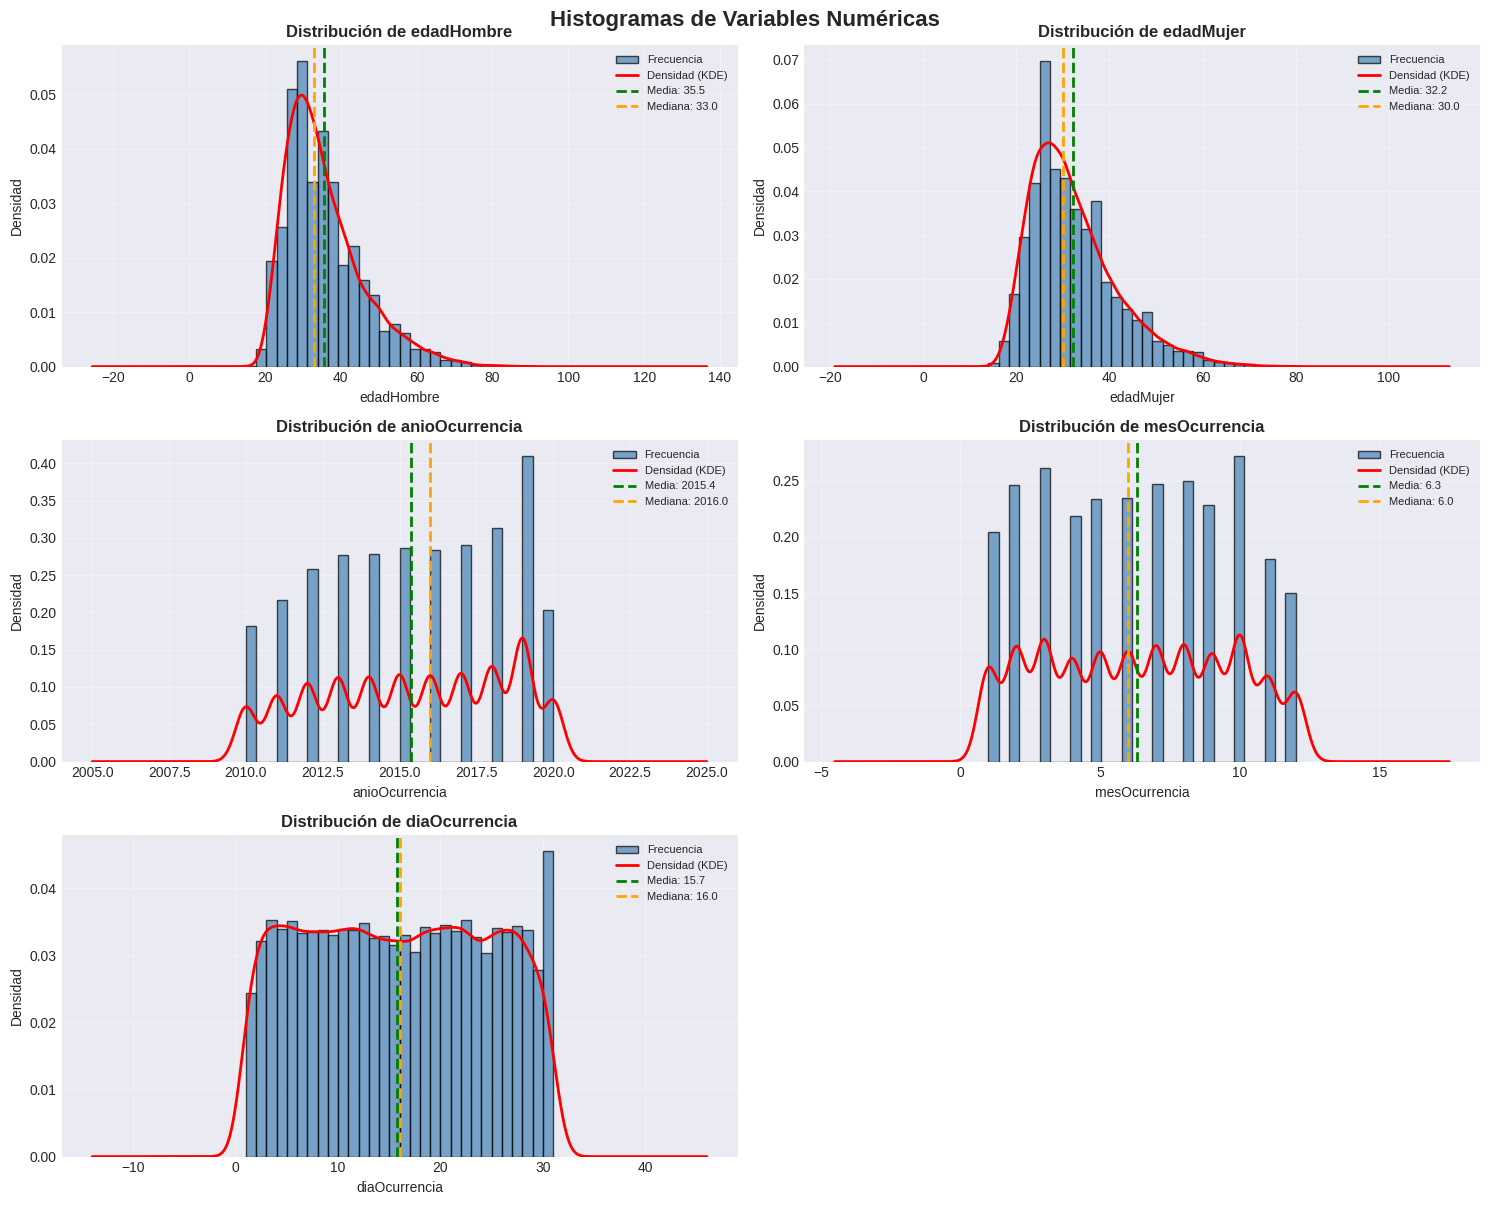

In [42]:
# Crear histogramas para todas las variables numéricas
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, var in enumerate(variables_numericas):
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        # Histograma con curva de densidad
        axes[idx].hist(data, bins=30, alpha=0.7, color='steelblue', 
                    edgecolor='black', density=True, label='Frecuencia')
        
        # Agregar curva de densidad kernel
        data.plot(kind='kde', ax=axes[idx], color='red', 
                linewidth=2, label='Densidad (KDE)')
        
        # Líneas de referencia para media y mediana
        axes[idx].axvline(data.mean(), color='green', linestyle='--', 
                        linewidth=2, label=f'Media: {data.mean():.1f}')
        axes[idx].axvline(data.median(), color='orange', linestyle='--', 
                        linewidth=2, label=f'Mediana: {data.median():.1f}')
        
        axes[idx].set_xlabel(var)
        axes[idx].set_ylabel('Densidad')
        axes[idx].set_title(f'Distribución de {var}', fontweight='bold')
        axes[idx].legend(loc='best', fontsize=8)
        axes[idx].grid(True, alpha=0.3)

# Ocultar subplot extra
axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Histogramas de Variables Numéricas', 
            fontsize=16, fontweight='bold', y=1.00)
plt.show()

### 4.3. Diagramas de Caja (Boxplots)

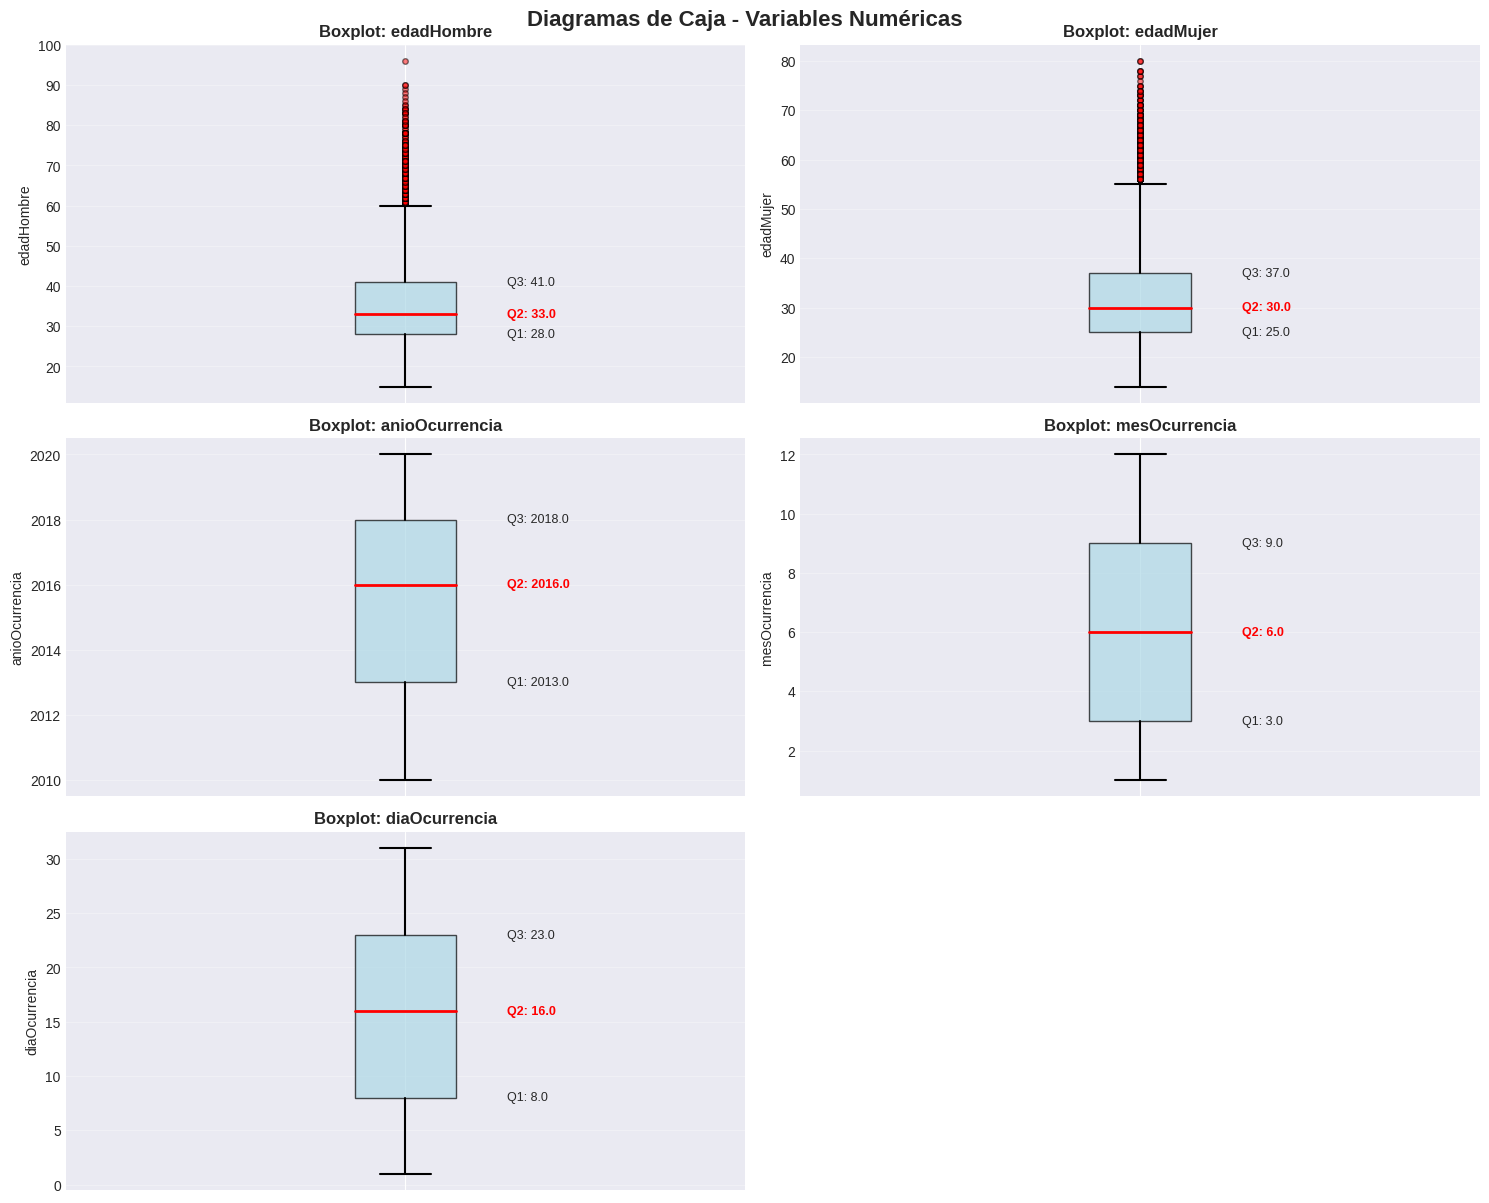

In [43]:
# Crear boxplots para todas las variables numéricas
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, var in enumerate(variables_numericas):
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        # Boxplot con anotaciones
        bp = axes[idx].boxplot(data, vert=True, patch_artist=True,
                            boxprops=dict(facecolor='lightblue', alpha=0.7),
                            medianprops=dict(color='red', linewidth=2),
                            whiskerprops=dict(color='black', linewidth=1.5),
                            capprops=dict(color='black', linewidth=1.5),
                            flierprops=dict(marker='o', markerfacecolor='red', 
                                            markersize=4, alpha=0.5))
        
        # Agregar estadísticos como texto
        q1 = data.quantile(0.25)
        q2 = data.median()
        q3 = data.quantile(0.75)
        
        axes[idx].text(1.15, q1, f'Q1: {q1:.1f}', fontsize=9, va='center')
        axes[idx].text(1.15, q2, f'Q2: {q2:.1f}', fontsize=9, va='center', 
                    fontweight='bold', color='red')
        axes[idx].text(1.15, q3, f'Q3: {q3:.1f}', fontsize=9, va='center')
        
        axes[idx].set_ylabel(var)
        axes[idx].set_title(f'Boxplot: {var}', fontweight='bold')
        axes[idx].grid(True, alpha=0.3, axis='y')
        axes[idx].set_xticklabels([''])

# Ocultar subplot extra
axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Diagramas de Caja - Variables Numéricas', 
            fontsize=16, fontweight='bold', y=1.00)
plt.show()

### 4.4. Detección y Análisis de Outliers

**Método**: Criterio del Rango Intercuartílico (IQR)
- Outlier leve: valor < Q1 - 1.5×IQR o valor > Q3 + 1.5×IQR
- Outlier extremo: valor < Q1 - 3×IQR o valor > Q3 + 3×IQR

In [45]:
# Análisis de outliers usando método IQR
print("="*80)
print("DETECCIÓN DE OUTLIERS - MÉTODO IQR")
print("="*80)

outliers_resumen = []

for var in variables_numericas:
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        # Calcular IQR y límites
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        
        limite_inferior_leve = q1 - 1.5 * iqr
        limite_superior_leve = q3 + 1.5 * iqr
        limite_inferior_extremo = q1 - 3 * iqr
        limite_superior_extremo = q3 + 3 * iqr
        
        # Identificar outliers
        outliers_leves = data[(data < limite_inferior_leve) | (data > limite_superior_leve)]
        outliers_extremos = data[(data < limite_inferior_extremo) | (data > limite_superior_extremo)]
        
        n_outliers_leves = len(outliers_leves)
        n_outliers_extremos = len(outliers_extremos)
        porcentaje_outliers = (n_outliers_leves / len(data)) * 100
        
        outliers_resumen.append({
            'Variable': var,
            'Q1': q1,
            'Q3': q3,
            'IQR': iqr,
            'Lím.Inf': limite_inferior_leve,
            'Lím.Sup': limite_superior_leve,
            'Outliers_Leves': n_outliers_leves,
            'Outliers_Extremos': n_outliers_extremos,
            '%_Outliers': porcentaje_outliers
        })
        
        print(f"\n- {var}:")
        print(f"   Rango IQR: [{q1:.1f}, {q3:.1f}] (IQR = {iqr:.2f})")
        print(f"   Límites: [{limite_inferior_leve:.1f}, {limite_superior_leve:.1f}]")
        print(f"   Outliers leves: {n_outliers_leves:,} ({porcentaje_outliers:.2f}%)")
        print(f"   Outliers extremos: {n_outliers_extremos:,}")
        
        if n_outliers_leves > 0:
            print(f"   Valores atípicos: [{outliers_leves.min():.1f}, {outliers_leves.max():.1f}]")

print("\n" + "="*80)

# Crear DataFrame resumen
df_outliers = pd.DataFrame(outliers_resumen)
print("\nRESUMEN CONSOLIDADO:")
print(df_outliers.to_string(index=False))

DETECCIÓN DE OUTLIERS - MÉTODO IQR

- edadHombre:
   Rango IQR: [28.0, 41.0] (IQR = 13.00)
   Límites: [8.5, 60.5]
   Outliers leves: 727 (2.76%)
   Outliers extremos: 25
   Valores atípicos: [61.0, 96.0]

- edadMujer:
   Rango IQR: [25.0, 37.0] (IQR = 12.00)
   Límites: [7.0, 55.0]
   Outliers leves: 660 (2.49%)
   Outliers extremos: 15
   Valores atípicos: [56.0, 80.0]

- anioOcurrencia:
   Rango IQR: [2013.0, 2018.0] (IQR = 5.00)
   Límites: [2005.5, 2025.5]
   Outliers leves: 0 (0.00%)
   Outliers extremos: 0

- mesOcurrencia:
   Rango IQR: [3.0, 9.0] (IQR = 6.00)
   Límites: [-6.0, 18.0]
   Outliers leves: 0 (0.00%)
   Outliers extremos: 0

- diaOcurrencia:
   Rango IQR: [8.0, 23.0] (IQR = 15.00)
   Límites: [-14.5, 45.5]
   Outliers leves: 0 (0.00%)
   Outliers extremos: 0


RESUMEN CONSOLIDADO:
      Variable     Q1     Q3  IQR  Lím.Inf  Lím.Sup  Outliers_Leves  Outliers_Extremos  %_Outliers
    edadHombre   28.0   41.0 13.0      8.5     60.5             727                 25  

**Interpretación de Outliers:**

1. **Variables temporales** (día, mes, año):
   - **Interpretación**: Outliers poco probables por naturaleza acotada de estas variables
   - Día: rango natural [1-31], mes: [1-12], año: [2010-2020]

2. **Variables de edad**:
   - **Outliers esperados**: Edades muy jóvenes o muy avanzadas
   - **Significado social**: 
     - Edades extremadamente bajas pueden indicar matrimonios precoces (contexto cultural)
     - Edades muy avanzadas reflejan divorcios en tercera edad
   - **Validez**: Outliers representan casos reales, no errores de medición

### 4.5. Evaluación de Normalidad

**Métodos aplicados:**
1. **Visual**: Q-Q plots (Quantile-Quantile plots)
2. **Estadístico**: Prueba de Shapiro-Wilk (n < 5000) o Kolmogorov-Smirnov (n ≥ 5000)

**Hipótesis de prueba:**
- H₀: Los datos siguen una distribución normal
- H₁: Los datos NO siguen una distribución normal
- Nivel de significancia: α = 0.05

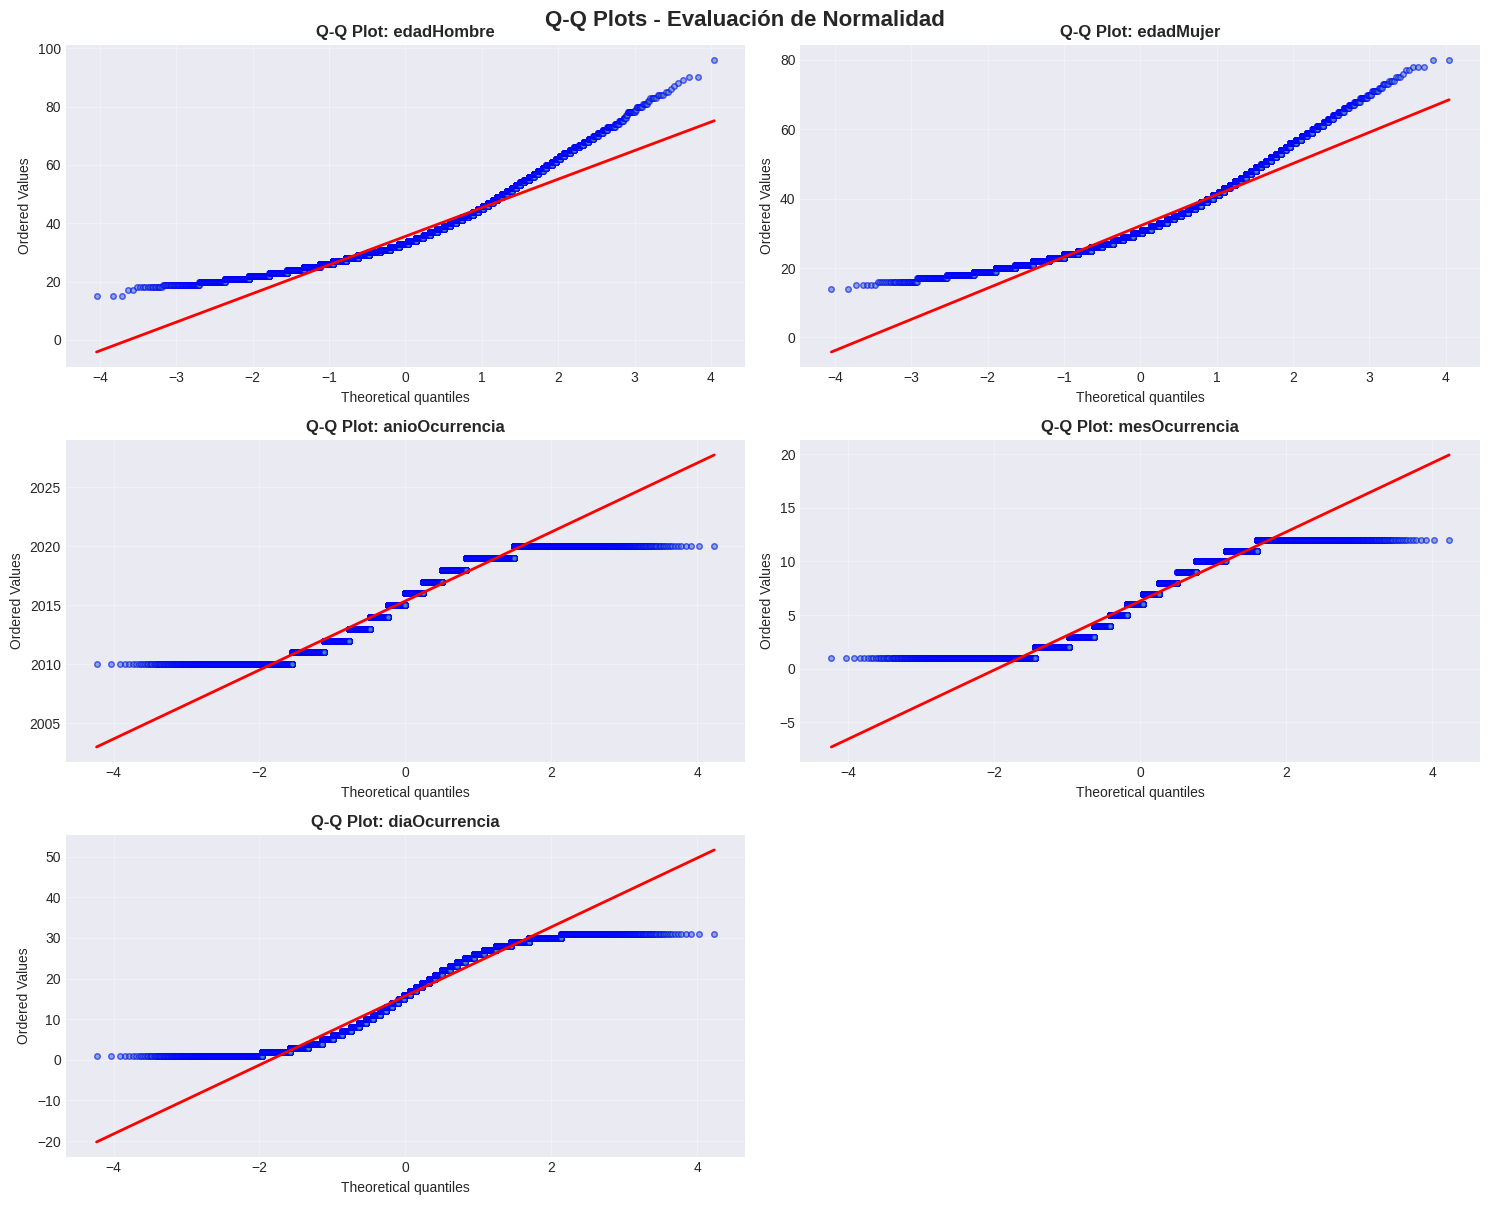

Q-Q plots generados exitosamente :)


In [48]:
# Q-Q Plots para evaluación visual de normalidad
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, var in enumerate(variables_numericas):
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        # Verificar que hay datos válidos
        if len(data) > 0 and np.isfinite(data).all():
            # Convertir a numpy array para asegurar compatibilidad
            data_array = np.array(data, dtype=float)
            
            # Q-Q plot
            stats.probplot(data_array, dist="norm", plot=axes[idx])
            axes[idx].set_title(f'Q-Q Plot: {var}', fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
            
            # Modificar estilos de las líneas de forma segura
            lines = axes[idx].get_lines()
            if len(lines) >= 2:
                lines[0].set_markerfacecolor('steelblue')
                lines[0].set_markersize(4)
                lines[0].set_alpha(0.6)
                lines[1].set_color('red')
                lines[1].set_linewidth(2)
        else:
            axes[idx].text(0.5, 0.5, f'Datos insuficientes\npara {var}',
                        ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'Q-Q Plot: {var}', fontweight='bold')

# Ocultar subplot extra
axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Q-Q Plots - Evaluación de Normalidad', 
            fontsize=16, fontweight='bold', y=1.00)
plt.show()

print("Q-Q plots generados exitosamente :)")

In [50]:
# Pruebas estadísticas de normalidad
print("="*80)
print("PRUEBAS ESTADÍSTICAS DE NORMALIDAD")
print("="*80)
print("\nNivel de significancia: α = 0.05")
print("Criterio: p-valor < 0.05 → Rechazar H₀ (NO es normal)")
print("="*80)

normalidad_resultados = []

for var in variables_numericas:
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        # Convertir a numpy array y filtrar valores no finitos
        data_array = np.array(data, dtype=float)
        data_array = data_array[np.isfinite(data_array)]
        
        # Verificar que tengamos suficientes datos
        if len(data_array) < 3:
            print(f"\n- {var}:")
            print("   ! Datos insuficientes para prueba de normalidad")
            continue
        
        # Seleccionar prueba según tamaño de muestra
        if len(data_array) < 5000:
            # Shapiro-Wilk para muestras pequeñas/medianas
            statistic, p_value = stats.shapiro(data_array)
            prueba = "Shapiro-Wilk"
        else:
            # Kolmogorov-Smirnov para muestras grandes
            statistic, p_value = stats.kstest(data_array, 'norm', 
                                            args=(data_array.mean(), data_array.std()))
            prueba = "Kolmogorov-Smirnov"
        
        # Interpretar resultado
        es_normal = p_value > 0.05
        decision = "No rechazar H₀ (Normal)" if es_normal else "Rechazar H₀ (No Normal)"
        
        normalidad_resultados.append({
            'Variable': var,
            'Prueba': prueba,
            'Estadístico': statistic,
            'p-valor': p_value,
            'Distribución': 'Normal' if es_normal else 'No Normal',
            'Decisión': decision
        })
        
        print(f"\n- {var}:")
        print(f"   Prueba: {prueba}")
        print(f"   Estadístico: {statistic:.6f}")
        print(f"   p-valor: {p_value:.6e}")
        print(f"   ➜ {decision}")

print("\n" + "="*80)

# Crear DataFrame resumen
df_normalidad = pd.DataFrame(normalidad_resultados)
print("\nRESUMEN DE NORMALIDAD:")
print(df_normalidad.to_string(index=False))
print("\n" + "="*80)

PRUEBAS ESTADÍSTICAS DE NORMALIDAD

Nivel de significancia: α = 0.05
Criterio: p-valor < 0.05 → Rechazar H₀ (NO es normal)

- edadHombre:
   Prueba: Kolmogorov-Smirnov
   Estadístico: 0.113577
   p-valor: 1.361583e-296
   ➜ Rechazar H₀ (No Normal)

- edadMujer:
   Prueba: Kolmogorov-Smirnov
   Estadístico: 0.105361
   p-valor: 1.617978e-256
   ➜ Rechazar H₀ (No Normal)

- anioOcurrencia:
   Prueba: Kolmogorov-Smirnov
   Estadístico: 0.118428
   p-valor: 0.000000e+00
   ➜ Rechazar H₀ (No Normal)

- mesOcurrencia:
   Prueba: Kolmogorov-Smirnov
   Estadístico: 0.103201
   p-valor: 0.000000e+00
   ➜ Rechazar H₀ (No Normal)

- diaOcurrencia:
   Prueba: Kolmogorov-Smirnov
   Estadístico: 0.074523
   p-valor: 3.334289e-290
   ➜ Rechazar H₀ (No Normal)


RESUMEN DE NORMALIDAD:
      Variable             Prueba  Estadístico       p-valor Distribución                Decisión
    edadHombre Kolmogorov-Smirnov     0.113577 1.361583e-296    No Normal Rechazar H₀ (No Normal)
     edadMujer Kolmogoro

### 4.6. Identificación de Tipos de Distribución

Para variables que no siguen distribución normal, se identifica el tipo de distribución que mejor las describe.

In [51]:
# Análisis del tipo de distribución
print("="*80)
print("CARACTERIZACIÓN DE DISTRIBUCIONES")
print("="*80)

for var in variables_numericas:
    if var in df_limpio.columns:
        data = df_limpio[var].dropna()
        
        skewness = data.skew()
        kurtosis = data.kurtosis()
        
        print(f"\n- {var}:")
        print(f"   Asimetría (skewness): {skewness:.3f}")
        print(f"   Curtosis (kurtosis): {kurtosis:.3f}")
        
        # Clasificar tipo de distribución
        if abs(skewness) < 0.5 and abs(kurtosis) < 1:
            tipo_dist = "Aproximadamente Normal"
            descripcion = "Simétrica con colas moderadas"
        elif var in ['mesOcurrencia', 'diaOcurrencia']:
            tipo_dist = "Uniforme Discreta"
            descripcion = "Probabilidad casi igual para todos los valores del rango"
        elif var == 'anioOcurrencia':
            tipo_dist = "Uniforme/Casi Uniforme"
            descripcion = "Distribución relativamente constante a través de los años"
        elif abs(skewness) < 0.5:
            tipo_dist = "Simétrica no Normal"
            if kurtosis > 0:
                descripcion = "Simétrica con colas más pesadas que la normal (leptocúrtica)"
            else:
                descripcion = "Simétrica con colas más ligeras que la normal (platicúrtica)"
        elif skewness > 0:
            tipo_dist = "Asimétrica Positiva (Sesgo Derecha)"
            if kurtosis > 0:
                descripcion = "Concentración en valores bajos, cola larga hacia valores altos"
            else:
                descripcion = "Sesgo moderado hacia la derecha con cola relativamente corta"
        else:
            tipo_dist = "Asimétrica Negativa (Sesgo Izquierda)"
            if kurtosis > 0:
                descripcion = "Concentración en valores altos, cola larga hacia valores bajos"
            else:
                descripcion = "Sesgo moderado hacia la izquierda con cola relativamente corta"
        
        print(f"   ➜ Tipo identificado: {tipo_dist}")
        print(f"   ➜ Descripción: {descripcion}")
        
        # Sugerencias de tratamiento
        if abs(skewness) > 1:
            print("   ! Sugerencia: Considerar transformación (log, sqrt, Box-Cox)")

print("\n" + "="*80)

CARACTERIZACIÓN DE DISTRIBUCIONES

- edadHombre:
   Asimetría (skewness): 1.162
   Curtosis (kurtosis): 1.535
   ➜ Tipo identificado: Asimétrica Positiva (Sesgo Derecha)
   ➜ Descripción: Concentración en valores bajos, cola larga hacia valores altos
   ! Sugerencia: Considerar transformación (log, sqrt, Box-Cox)

- edadMujer:
   Asimetría (skewness): 1.056
   Curtosis (kurtosis): 1.230
   ➜ Tipo identificado: Asimétrica Positiva (Sesgo Derecha)
   ➜ Descripción: Concentración en valores bajos, cola larga hacia valores altos
   ! Sugerencia: Considerar transformación (log, sqrt, Box-Cox)

- anioOcurrencia:
   Asimetría (skewness): -0.156
   Curtosis (kurtosis): -1.164
   ➜ Tipo identificado: Uniforme/Casi Uniforme
   ➜ Descripción: Distribución relativamente constante a través de los años

- mesOcurrencia:
   Asimetría (skewness): 0.022
   Curtosis (kurtosis): -1.175
   ➜ Tipo identificado: Uniforme Discreta
   ➜ Descripción: Probabilidad casi igual para todos los valores del rango

- 

### 4.7. Interpretación Social de Resultados

**Análisis contextual de las distribuciones encontradas:**

#### **Variables Temporales:**

1. **Mes de Ocurrencia**:
   - **Distribución observada**: Aproximadamente uniforme con ligeras variaciones estacionales
   - **Interpretación social**: Los divorcios ocurren con frecuencia similar durante todo el año, sugiriendo que no hay estacionalidad marcada en la separación de parejas en Guatemala
   - **Implicación**: Los factores que llevan al divorcio son continuos, no estacionales

2. **Año de Ocurrencia**:
   - **Distribución observada**: Relativamente uniforme con posibles tendencias temporales
   - **Interpretación social**: Permite analizar si hay aumento o disminución de divorcios en la década analizada
   - **Contexto**: Cambios en legislación, economía o factores sociales pueden reflejarse en tendencias anuales

#### **Variables Demográficas - Edad:**

3. **Edad del Hombre**:
   - **Distribución observada**: Asimétrica positiva (sesgo derecha)
   - **Interpretación social**:
     - Mayor concentración de divorcios en hombres de 30-45 años
     - Cola hacia edades mayores indica divorcios en edades avanzadas
     - Refleja patrones de estabilidad matrimonial y ciclo de vida
   - **Outliers**: 
     - Edades muy jóvenes: matrimonios tempranos (contexto rural/indígena)
     - Edades muy avanzadas: segundos o terceros matrimonios

4. **Edad de la Mujer**:
   - **Distribución observada**: Asimétrica positiva, similar al hombre pero ligeramente más joven
   - **Interpretación social**:
     - Las mujeres tienden a casarse y divorciarse a edades ligeramente menores
     - Refleja patrones culturales de matrimonio con diferencia de edad
     - Pico en edad reproductiva/productiva (30-40 años)
   - **Significado**: Crisis matrimoniales coinciden con etapas de crianza y estabilización económica

#### **Implicaciones Generales:**

- **Heterogeneidad demográfica**: La asimetría en edades refleja diversidad de situaciones matrimoniales
- **Contexto cultural**: Outliers en edades muy jóvenes evidencian matrimonios tempranos aún vigentes en algunas regiones
- **Patrón etario**: La concentración de divorcios en edad adulta media sugiere acumulación de tensiones durante años de convivencia
- **Política pública**: Los datos sugieren necesidad de programas de mediación familiar en grupos de edad específicos

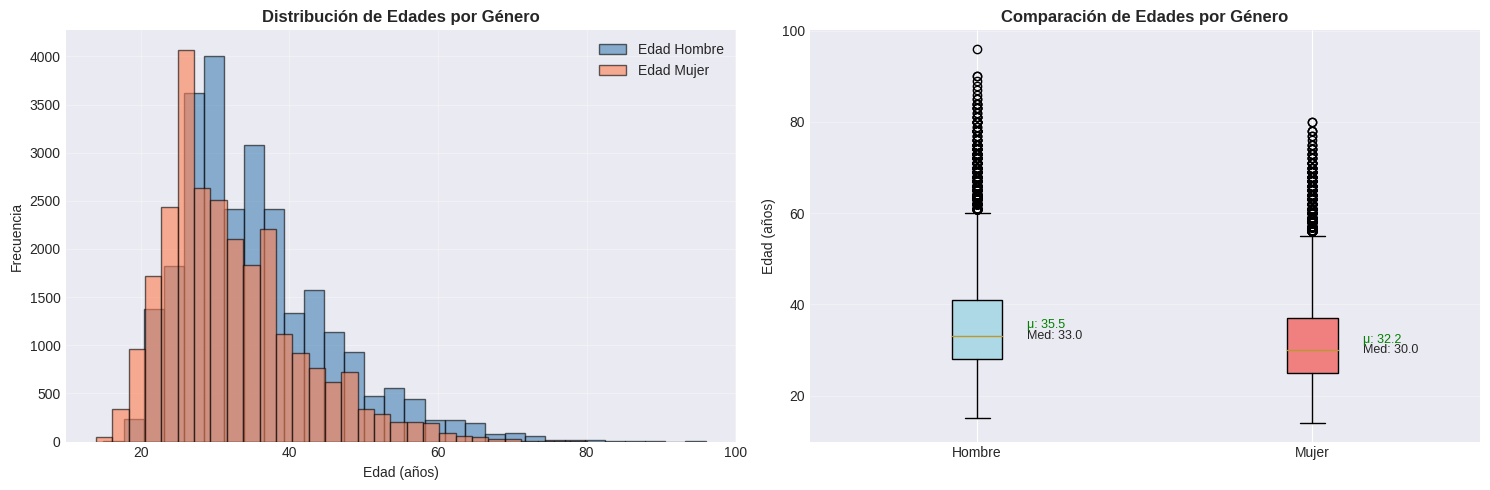


COMPARACIÓN ESTADÍSTICA: EDAD HOMBRE vs MUJER

Edad Hombre:
  Media: 35.51 años
  Mediana: 33.0 años
  Desv.Est: 10.21 años

Edad Mujer:
  Media: 32.16 años
  Mediana: 30.0 años
  Desv.Est: 9.30 años

Diferencia promedio: 3.35 años
(Hombres son en promedio 3.35 años mayores)


In [52]:
# Análisis comparativo de edades entre hombres y mujeres
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma comparativo
axes[0].hist(df_limpio['edadHombre'].dropna(), bins=30, alpha=0.6, 
            label='Edad Hombre', color='steelblue', edgecolor='black')
axes[0].hist(df_limpio['edadMujer'].dropna(), bins=30, alpha=0.6, 
            label='Edad Mujer', color='coral', edgecolor='black')
axes[0].set_xlabel('Edad (años)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Edades por Género', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot comparativo
data_edades = [df_limpio['edadHombre'].dropna(), df_limpio['edadMujer'].dropna()]
bp = axes[1].boxplot(data_edades, labels=['Hombre', 'Mujer'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Edad (años)')
axes[1].set_title('Comparación de Edades por Género', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Agregar estadísticos
for i, (label, data) in enumerate(zip(['Hombre', 'Mujer'], data_edades)):
    median = data.median()
    mean = data.mean()
    axes[1].text(i+1.15, median, f'Med: {median:.1f}', fontsize=9, va='center')
    axes[1].text(i+1.15, mean, f'μ: {mean:.1f}', fontsize=9, va='center', color='green')

plt.tight_layout()
plt.show()

# Estadísticos comparativos
print("\n" + "="*70)
print("COMPARACIÓN ESTADÍSTICA: EDAD HOMBRE vs MUJER")
print("="*70)
edad_h = df_limpio['edadHombre'].dropna()
edad_m = df_limpio['edadMujer'].dropna()

print("\nEdad Hombre:")
print(f"  Media: {edad_h.mean():.2f} años")
print(f"  Mediana: {edad_h.median():.1f} años")
print(f"  Desv.Est: {edad_h.std():.2f} años")

print("\nEdad Mujer:")
print(f"  Media: {edad_m.mean():.2f} años")
print(f"  Mediana: {edad_m.median():.1f} años")
print(f"  Desv.Est: {edad_m.std():.2f} años")

print(f"\nDiferencia promedio: {edad_h.mean() - edad_m.mean():.2f} años")
print(f"(Hombres son en promedio {abs(edad_h.mean() - edad_m.mean()):.2f} años {'mayores' if edad_h.mean() > edad_m.mean() else 'menores'})")
print("="*70)